In [1]:
library(tidyverse)
library(inspectdf)
library(tidylog)
library(purrr)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tidylog’


The following objects are masked from ‘package:dplyr’:

    add_count, add_tally, anti_join, count, distinct, distinct_all,
    distinct_at, distinct_if, filter, filter_all, filter_at, filter_if,
    full_join, group_by, group_by_all,

In [2]:
coredata <- read.csv("../41467_2025_59204_MOESM4_ESM/Supplementary Software/Core_data.csv" , fileEncoding = "UTF-8")

In [4]:
dim(coredata)

[1] 19650    33

In [7]:
coredata_slices <-  coredata %>%
                    dplyr::select(!c(Primary.reference, Secondary.reference)) %>%
                    dplyr::mutate(depth_interval = Top.of.section + Thickness.sediment.slice) %>%
                    dplyr::relocate(depth_interval, .before = Corg) %>%
                    dplyr::mutate(Depth.at.center.of.slice = Top.of.section + (Thickness.sediment.slice/2),
                                  Corg_DBD = Dry.Bulk.Density * (Corg/100), 
                                  Carbon_density = Corg_DBD * Thickness.sediment.slice,
                                  Corg_DBD = Dry.Bulk.Density * (Corg/100), Corg_DBD_interval = Corg_DBD * Thickness.sediment.slice) |>
                    dplyr::group_by(across(all_of(c("Article.ID", "Site.name", "Country", "Latitude", "Longitude", "Species", "Core.ID")))) |>
                    dplyr::mutate(carbon_stock_MgC_ha = cumsum(Corg_DBD_interval) * (1/1000000) * (100000000/1)) |>
                    dplyr::ungroup() |>
                    dplyr::select(all_of(c("Article.ID", "Publication.year", "Site.name", "Country", "Latitude", 
                                            "Longitude", "Species", "Core.ID", "Top.of.section", "Bottom.of.section", 
                                            "Depth.at.center.of.slice", "Thickness.sediment.slice", "Dry.Bulk.Density", 
                                            "depth_interval", "Corg","Corg_DBD", "Carbon_density", "carbon_stock_MgC_ha"))) |>
                    dplyr::filter(Site.name == "Aburatsubo Bay")

[1] 26 18

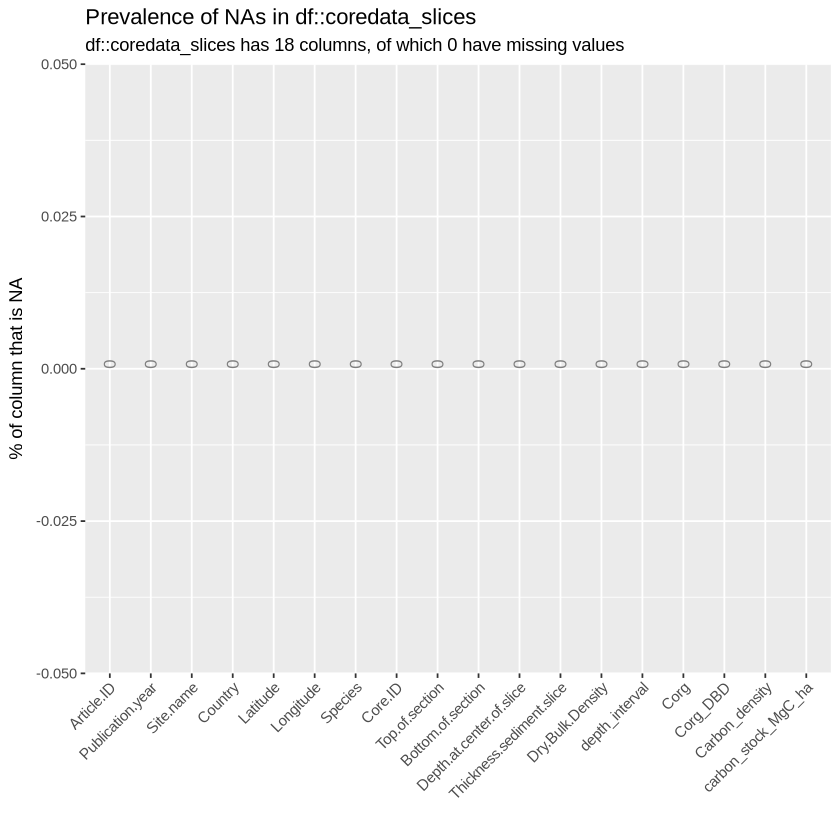

In [8]:
dim(coredata_slices)
inspectdf::inspect_na(coredata_slices) |> inspectdf::show_plot()

In [9]:
glimpse(coredata_slices)

Rows: 26
Columns: 18
$ Article.ID               <chr> "CC_012", "CC_012", "CC_012", "CC_012", "CC_0…
$ Publication.year         <int> 2002, 2002, 2002, 2002, 2002, 2002, 2002, 200…
$ Site.name                <chr> "Aburatsubo Bay", "Aburatsubo Bay", "Aburatsu…
$ Country                  <chr> "Japan", "Japan", "Japan", "Japan", "Japan", …
$ Latitude                 <dbl> 35.157, 35.157, 35.157, 35.157, 35.157, 35.15…
$ Longitude                <dbl> 139.612, 139.612, 139.612, 139.612, 139.612, …
$ Species                  <chr> "Zostera sp.", "Zostera sp.", "Zostera sp.", …
$ Core.ID                  <chr> "104", "104", "104", "105", "105", "105", "10…
$ Top.of.section           <dbl> -0.2000000, 4.0000000, 8.5000000, 1.5000000, …
$ Bottom.of.section        <dbl> 3.800000, 8.000000, 12.500000, 4.500000, 7.50…
$ Depth.at.center.of.slice <dbl> 1.8000000, 6.0000000, 10.5000000, 3.0000000, …
$ Thickness.sediment.slice <dbl> 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, …
$ Dry.Bulk.Density 

In [10]:
xtabs(~ Site.name, data = coredata_slices)

Site.name
Aburatsubo Bay 
            26 

In [11]:
interpolate_slice <- function(data, x_val) {
  # Return NA if x_val is NA
  if (is.na(x_val)) return(NA_real_)

  # Rename columns to standard names (assumes only two columns: x and y)
  clean_data <- data %>%
    setNames(c("x", "y")) %>%
    filter(!is.na(x) & !is.na(y))

  if (nrow(clean_data) == 0) return(NA_real_)

  if (x_val > max(clean_data$x, na.rm = TRUE)) {
    return(NA_real_)
  }

  model <- lm(y ~ x, data = clean_data)

  predict(model, newdata = data.frame(x = x_val))
}

In [12]:
colnames(coredata_slices)

[1] "Article.ID"               "Publication.year"        
 [3] "Site.name"                "Country"                 
 [5] "Latitude"                 "Longitude"               
 [7] "Species"                  "Core.ID"                 
 [9] "Top.of.section"           "Bottom.of.section"       
[11] "Depth.at.center.of.slice" "Thickness.sediment.slice"
[13] "Dry.Bulk.Density"         "depth_interval"          
[15] "Corg"                     "Corg_DBD"                
[17] "Carbon_density"           "carbon_stock_MgC_ha"

In [13]:
soc_vars <- c("Corg", "Dry.Bulk.Density")
soc_depths  <- c(15, 20, 30, 50)         

In [14]:
get_slice_val <- function(data, x_col, y_col, x_val) {
  match_row <- data[data[[x_col]] == x_val, , drop = FALSE]
  if (nrow(match_row) == 0) return(NA_real_)
  return(match_row[[y_col]][1])
}

In [15]:
get_slice_val <- function(data, x_val) {
  # Ensure input is a data.frame and has at least 2 columns
  if (!is.data.frame(data) || ncol(data) < 2) return(NA_real_)
  
  x_col <- names(data)[1]
  y_col <- names(data)[2]
  
  # If either column is missing, return NA
  if (is.null(x_col) || is.null(y_col)) return(NA_real_)
  
  # Defensive: ensure x_col has non-NA entries to check
  if (!x_col %in% names(data) || !y_col %in% names(data)) return(NA_real_)
  
  # Filter for exact match
  match_row <- data[data[[x_col]] == x_val, , drop = FALSE]
  
  # Return NA if no match
  if (nrow(match_row) == 0) return(NA_real_)
  
  return(match_row[[y_col]][1])
}


In [16]:
grouping_cols <- c("Article.ID", "Site.name", "Country", "Latitude", "Longitude", "Species", "Core.ID")

In [17]:
na_report_list <- list()

core_varx_depthx_list <- lapply(soc_vars, function(varx) {
  
    lapply(soc_depths, function(depthx) {

    var_name <- paste0(varx, "_", depthx)
    int_var_name <- paste0("int_", varx, "_", depthx)
    N_sample_count <-  paste0("stat_N_sample_", varx)
    n_count <-  paste0("stat_n_sample_", varx)

    df <- coredata_slices |>
          dplyr::group_by(across(all_of(grouping_cols))) |>
          dplyr::summarise(!!N_sample_count := sum(!is.na(.data[[varx]])),
                           !!n_count := n(),
                           Depth.of.core = max(Bottom.of.section),
                           !!var_name := get_slice_val(pick(depth_interval, all_of(varx)), x_val = depthx),
                           !!int_var_name := interpolate_slice(pick(depth_interval, all_of(varx)), x_val = depthx),
                           .groups = "drop") |>
          dplyr::ungroup() 

    return(df)
  })
})


filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows 

In [20]:
core_varx_depthx_df <- Reduce(function(x, y) merge(x, y), core_varx_depthx_list)

In [21]:
colnames(core_varx_depthx_df)

[1] "Article.ID"                       "Site.name"                       
 [3] "Country"                          "Latitude"                        
 [5] "Longitude"                        "Species"                         
 [7] "Core.ID"                          "Depth.of.core"                   
 [9] "Article.ID.1"                     "Site.name.1"                     
[11] "Country.1"                        "Latitude.1"                      
[13] "Longitude.1"                      "Species.1"                       
[15] "Core.ID.1"                        "Depth.of.core.1"                 
[17] "Article.ID.2"                     "Site.name.2"                     
[19] "Country.2"                        "Latitude.2"                      
[21] "Longitude.2"                      "Species.2"                       
[23] "Core.ID.2"                        "Depth.of.core.2"                 
[25] "Article.ID.3"                     "Site.name.3"                     
[27] "Country.3"                        "Latitude.3"                      
[29] "Longitude.3"                      "Species.3"                       
[31] "Core.ID.3"                        "Depth.of.core.3"                 
[33] "stat_N_sample_Corg"               "stat_n_sample_Corg"              
[35] "Corg_15"                          "int_Corg_15"                     
[37] "stat_N_sample_Corg.1"             "stat_n_sample_Corg.1"            
[39] "Corg_20"                          "int_Corg_20"                     
[41] "stat_N_sample_Corg.2"             "stat_n_sample_Corg.2"            
[43] "Corg_30"                          "int_Corg_30"                     
[45] "stat_N_sample_Corg.3"             "stat_n_sample_Corg.3"            
[47] "Corg_50"                          "int_Corg_50"                     
[49] "stat_N_sample_Dry.Bulk.Density"   "stat_n_sample_Dry.Bulk.Density"  
[51] "Dry.Bulk.Density_15"              "int_Dry.Bulk.Density_15"         
[53] "stat_N_sample_Dry.Bulk.Density.1" "stat_n_sample_Dry.Bulk.Density.1"
[55] "Dry.Bulk.Density_20"              "int_Dry.Bulk.Density_20"         
[57] "stat_N_sample_Dry.Bulk.Density.2" "stat_n_sample_Dry.Bulk.Density.2"
[59] "Dry.Bulk.Density_30"              "int_Dry.Bulk.Density_30"         
[61] "stat_N_sample_Dry.Bulk.Density.3" "stat_n_sample_Dry.Bulk.Density.3"
[63] "Dry.Bulk.Density_50"              "int_Dry.Bulk.Density_50"

In [244]:
merged_dfx <- Reduce(function(x, y)  merge(x, y), core_varx_depthx_list)

In [245]:
colnames(merged_dfx)

[1] "Article.ID"                       "Site.name"                       
 [3] "Country"                          "Latitude"                        
 [5] "Longitude"                        "Species"                         
 [7] "Core.ID"                          "Depth.of.core"                   
 [9] "Article.ID.1"                     "Site.name.1"                     
[11] "Country.1"                        "Latitude.1"                      
[13] "Longitude.1"                      "Species.1"                       
[15] "Core.ID.1"                        "Depth.of.core.1"                 
[17] "Article.ID.2"                     "Site.name.2"                     
[19] "Country.2"                        "Latitude.2"                      
[21] "Longitude.2"                      "Species.2"                       
[23] "Core.ID.2"                        "Depth.of.core.2"                 
[25] "Article.ID.3"                     "Site.name.3"                     
[27] "Country.3"                        "Latitude.3"                      
[29] "Longitude.3"                      "Species.3"                       
[31] "Core.ID.3"                        "Depth.of.core.3"                 
[33] "stat_N_sample_Corg"               "stat_n_sample_Corg"              
[35] "Corg_15"                          "int_Corg_15"                     
[37] "stat_N_sample_Corg.1"             "stat_n_sample_Corg.1"            
[39] "Corg_20"                          "int_Corg_20"                     
[41] "stat_N_sample_Corg.2"             "stat_n_sample_Corg.2"            
[43] "Corg_30"                          "int_Corg_30"                     
[45] "stat_N_sample_Corg.3"             "stat_n_sample_Corg.3"            
[47] "Corg_50"                          "int_Corg_50"                     
[49] "stat_N_sample_Dry.Bulk.Density"   "stat_n_sample_Dry.Bulk.Density"  
[51] "Dry.Bulk.Density_15"              "int_Dry.Bulk.Density_15"         
[53] "stat_N_sample_Dry.Bulk.Density.1" "stat_n_sample_Dry.Bulk.Density.1"
[55] "Dry.Bulk.Density_20"              "int_Dry.Bulk.Density_20"         
[57] "stat_N_sample_Dry.Bulk.Density.2" "stat_n_sample_Dry.Bulk.Density.2"
[59] "Dry.Bulk.Density_30"              "int_Dry.Bulk.Density_30"         
[61] "stat_N_sample_Dry.Bulk.Density.3" "stat_n_sample_Dry.Bulk.Density.3"
[63] "Dry.Bulk.Density_50"              "int_Dry.Bulk.Density_50"

In [98]:
for df in core_varx_depthx_list

[[1]]
NULL

In [99]:
na_report_list[1]

[[1]]
NULL

In [100]:
grouping_cols

[1] "Article.ID" "Site.name"  "Country"    "Latitude"   "Longitude" 
[6] "Species"    "Core.ID"

In [101]:
# Recursive full join across all data frames in the list
core_varx_depthx_df <- reduce(core_varx_depthx_df_list, full_join, by = key_cols)

full_join: added 3 columns (N_cores.x, N_cores.y, Corg_20)
           > rows only in out  0
           > rows only in elt  0
           > matched rows      6
           >                  ===
           > rows total        6
full_join: added 2 columns (N_cores, Corg_30)
           > rows only in out  0
           > rows only in elt  0
           > matched rows      6
           >                  ===
           > rows total        6
full_join: added 3 columns (N_cores.x.x, N_cores.y.y, Corg_50)
           > rows only in out  0
           > rows only in elt  0
           > matched rows      6
           >                  ===
           > rows total        6
full_join: added 2 columns (N_cores, Dry.Bulk.Density_15)
           > rows only in out  0
           > rows only in elt  0
           > matched rows      6
           >                  ===
           > rows total        6
full_join: added 3 columns (N_cores.x.x.x, N_cores.y.y.y, Dry.Bulk.Density_20)
           > rows only in out  

In [108]:
core_varx_depthx_list

Article.ID,Site.name,Country,Latitude,Longitude,Species,Core.ID,Depth.of.core,Corg_15,int_Corg_15
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,104,12.500000,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,105,12.000000,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,106,26.600000,NA,0.8533644
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,107,11.065217,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,108,17.652174,NA,0.3704489
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,109,7.586957,NA,NA
Article.ID,Site.name,Country,Latitude,Longitude,Species,Core.ID,Depth.of.core,Corg_20,int_Corg_20
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,104,12.500000,NA,NA


In [163]:
Reduce(function(x, y) merge(x, y, by = grouping_cols), core_varx_depthx_list)

Article.ID,Site.name,Country,Latitude,Longitude,Species,Core.ID,stat_N_sample_Corg,stat_n_sample_Corg,Depth.of.core.x,⋯,Country.3.y,Latitude.3.y,Longitude.3.y,Species.3.y,Core.ID.3.y,stat_N_sample_Dry.Bulk.Density.3,stat_n_sample_Dry.Bulk.Density.3,Depth.of.core.3.y,Dry.Bulk.Density_50,int_Dry.Bulk.Density_50
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,104,3,3,12.500000,⋯,Japan,35.157,139.612,Zostera sp.,104,3,3,12.500000,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,105,4,4,12.000000,⋯,Japan,35.157,139.612,Zostera sp.,105,4,4,12.000000,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,106,7,7,26.600000,⋯,Japan,35.157,139.612,Zostera sp.,106,7,7,26.600000,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,107,4,4,11.065217,⋯,Japan,35.157,139.612,Zostera sp.,107,4,4,11.065217,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,108,5,5,17.652174,⋯,Japan,35.157,139.612,Zostera sp.,108,5,5,17.652174,NA,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,109,3,3,7.586957,⋯,Japan,35.157,139.612,Zostera sp.,109,3,3,7.586957,NA,NA


In [16]:
(core_varx_depthx_df <- do.call(cbind, core_varx_depthx_list))

"CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan , Japan , Japan , Japan , Japan , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , 104 , 105 , 106 , 107 , 108 , 109 , 3 , 4 , 7 , 4 , 5 , 3 , 12.5 , 12 , 26.6 , 11.06521739 , 17.65217391 , 7.586956522 , NA , NA , NA , NA , NA , NA","CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan , Japan , Japan , Japan , Japan , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , 104 , 105 , 106 , 107 , 108 , 109 , 3 , 4 , 7 , 4 , 5 , 3 , 12.5 , 12 , 26.6 , 11.06521739 , 17.65217391 , 7.586956522 , NA , NA , NA , NA , NA , NA"
"CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan , Japan , Japan , Japan , Japan , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , 104 , 105 , 106 , 107 , 108 , 109 , 3 , 4 , 7 , 4 , 5 , 3 , 12.5 , 12 , 26.6 , 11.06521739 , 17.65217391 , 7.586956522 , NA , NA , 0.36 , NA , NA , NA","CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan , Japan , Japan , Japan , Japan , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , 104 , 105 , 106 , 107 , 108 , 109 , 3 , 4 , 7 , 4 , 5 , 3 , 12.5 , 12 , 26.6 , 11.06521739 , 17.65217391 , 7.586956522 , NA , NA , 1.091 , NA , NA , NA"
"CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan , Japan , Japan , Japan , Japan , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , 104 , 105 , 106 , 107 , 108 , 109 , 3 , 4 , 7 , 4 , 5 , 3 , 12.5 , 12 , 26.6 , 11.06521739 , 17.65217391 , 7.586956522 , NA , NA , NA , NA , NA , NA","CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan , Japan , Japan , Japan , Japan , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , 104 , 105 , 106 , 107 , 108 , 109 , 3 , 4 , 7 , 4 , 5 , 3 , 12.5 , 12 , 26.6 , 11.06521739 , 17.65217391 , 7.586956522 , NA , NA , NA , NA , NA , NA"
"CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan , Japan , Japan , Japan , Japan , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 35.157 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , 139.612 , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , Zostera sp. , 104 , 105 , 106 , 107 , 108 , 109 , 3 , 4 , 7 , 4 , 5 , 3 , 12.5 , 12 , 26.6 , 11.06521739 , 17.65217391 , 7.586956522 , NA , NA , NA , NA , NA , NA","CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , CC_012 , Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Aburatsubo Bay, Japan , Japan ,

In [29]:
grouping_cols

[1] "Article.ID" "Site.name"  "Country"    "Latitude"   "Longitude" 
[6] "Species"    "Core.ID"

In [14]:
na_report_list <- list()

core_varx_depthx_list <- lapply(soc_vars, function(varx) {
  lapply(soc_depths, function(depthx) {

    var_name <- paste0(varx, "_", depthx)
    int_var_name <- paste0("int_", varx, "_", depthx)

    df <- coredata_slices |>
      dplyr::group_by(across(all_of(c("Article.ID", "Site.name", "Country", "Latitude", "Longitude", "Species", "Core.ID")))) |>
      dplyr::summarise(
        N_cores = n(),
        Depth.of.core = max(Bottom.of.section),
        !!var_name := get_slice_val(pick(depth_interval, all_of(varx)), x_val = depthx),
        !!int_var_name := interpolate_slice(pick(depth_interval, all_of(varx)), x_val = depthx),
        .groups = "drop"
      )

    # Capture NA report
    na_report <- inspectdf::inspect_na(df) |>
      dplyr::filter(col_name %in% c(var_name, int_var_name)) |>
      dplyr::mutate(variable = varx, depth = depthx)

    # Save to global list
    key <- paste0(varx, "_", depthx)
    na_report_list[[key]] <<- na_report

    # Optionally drop the interpolated value column (or keep both)
    df |> select(-all_of(int_var_name))
  })
})


filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
select: dropped one variable (int_Corg_15)
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
select: dropped one variable (int_Corg_20)
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
select: dropped one variable (int_Corg_30)
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
select: dropped one variable (int_Corg_50)
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
filter: no rows removed
select: dropped one variable (int_Dry.Bulk.Density_15)
filter: no rows removed
filter: no rows removed
filte

In [17]:
# Flatten the nested list of data frames
core_varx_depthx_df_list <- unlist(core_varx_depthx_list, recursive = FALSE)

# Merge all data frames by common key columns (adjust keys as needed)
key_cols <- c("Article.ID", "Site.name", "Country", "Latitude", "Longitude", "Species", "Core.ID", "Depth.of.core")

# Perform a full join on all elements of the list using the key columns
core_varx_depthx_df <- Reduce(function(x, y) {
  full_join(x, y, by = key_cols)
}, core_varx_depthx_df_list)


full_join: added 3 columns (N_cores.x, N_cores.y, Corg_20)
           > rows only in x  0
           > rows only in y  0
           > matched rows    6
           >                ===
           > rows total      6
full_join: added 2 columns (N_cores, Corg_30)
           > rows only in x  0
           > rows only in y  0
           > matched rows    6
           >                ===
           > rows total      6
full_join: added 3 columns (N_cores.x.x, N_cores.y.y, Corg_50)
           > rows only in x  0
           > rows only in y  0
           > matched rows    6
           >                ===
           > rows total      6
full_join: added 2 columns (N_cores, Dry.Bulk.Density_15)
           > rows only in x  0
           > rows only in y  0
           > matched rows    6
           >                ===
           > rows total      6
full_join: added 3 columns (N_cores.x.x.x, N_cores.y.y.y, Dry.Bulk.Density_20)
           > rows only in x  0
           > rows only in y  0
         

In [18]:
(na_report_df <- dplyr::bind_rows(na_report_list, .id = "var_depth_key"))

var_depth_key,col_name,cnt,pcnt,variable,depth
<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>
Corg_15,Corg_15,6,100.00000,Corg,15
Corg_15,int_Corg_15,4,66.66667,Corg,15
Corg_20,Corg_20,5,83.33333,Corg,20
Corg_20,int_Corg_20,5,83.33333,Corg,20
Corg_30,Corg_30,6,100.00000,Corg,30
Corg_30,int_Corg_30,6,100.00000,Corg,30
Corg_50,Corg_50,6,100.00000,Corg,50
Corg_50,int_Corg_50,6,100.00000,Corg,50
Dry.Bulk.Density_15,Dry.Bulk.Density_15,6,100.00000,Dry.Bulk.Density,15


In [19]:
colnames(core_varx_depthx_df)

[1] "Article.ID"          "Site.name"           "Country"            
 [4] "Latitude"            "Longitude"           "Species"            
 [7] "Core.ID"             "N_cores.x"           "Depth.of.core"      
[10] "Corg_15"             "N_cores.y"           "Corg_20"            
[13] "N_cores.x.x"         "Corg_30"             "N_cores.y.y"        
[16] "Corg_50"             "N_cores.x.x.x"       "Dry.Bulk.Density_15"
[19] "N_cores.y.y.y"       "Dry.Bulk.Density_20" "N_cores.x.x.x.x"    
[22] "Dry.Bulk.Density_30" "N_cores.y.y.y.y"     "Dry.Bulk.Density_50"

In [20]:
core_varx_depthx_list

Article.ID,Site.name,Country,Latitude,Longitude,Species,Core.ID,N_cores,Depth.of.core,Corg_15
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,104,3,12.500000,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,105,4,12.000000,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,106,7,26.600000,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,107,4,11.065217,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,108,5,17.652174,NA
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,109,3,7.586957,NA
Article.ID,Site.name,Country,Latitude,Longitude,Species,Core.ID,N_cores,Depth.of.core,Corg_20
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>
CC_012,Aburatsubo Bay,Japan,35.157,139.612,Zostera sp.,104,3,12.500000,NA


In [21]:
#kruase_stocks <- read.csv("../41467_2025_59204_MOESM4_ESM/Supplementary Software/stocks.csv")

In [22]:
# kruase_stocks |> 
# filter(Article.ID == "CC_004" & Publication.year == 2021 & Study.site =="Barker Inlet")

In [23]:
# (krause_cols <- kruase_stocks |>
#                 dplyr::select(where(is.character)) |>
#                 colnames() |>
#                 dput())

In [24]:
#dplyr::glimpse(kruase_stocks) 

In [25]:
#kruase_stocks

In [26]:
# c("Article.ID", "Publication.year", "Site.name", "Country", "Latitude", 
# "Longitude", "Species", "Core.ID", "Top.of.section", "Bottom.of.section", 
# "Depth.at.center.of.slice", "Thickness.sediment.slice", "Dry.Bulk.Density", 
# "OM.content", "OM.density", "depth_interval", "Corg", "Cinorg", 
# "Cinorg.stock.increment", "Corg.stock.increment", "Ctot.stock.increment", 
# "DBD.core", "OM.content.core", "Corg.core", "Cinorg.core", "Cinorg.stock.core", 
# "Corg.stock.core", "Ctot.stock.core", "Depth.of.core", "Corg_DBD", 
# "Corg_DBD_interval", "carbon_stock_MgC_ha")

In [27]:
dim(coredata)

[1] 19650    33

In [28]:
colnames(by_coreID)

ERROR: Error: object 'by_coreID' not found


In [ ]:
interpolate_slice <- function(data, x_col, y_col, x_val) {

  message(str(data))
  # Return NA if x_val itself is NA
  if (is.na(x_val)) return(NA_real_)

  # Remove rows with NA in x or y
  clean_data <- data[!is.na(data[[x_col]]) & !is.na(data[[y_col]]), , drop = FALSE]

  # If clean data is empty, return NA
  if (nrow(clean_data) == 0) return(NA_real_)

  x_vals <- clean_data[[x_col]]

  # If x_val is greater than max of training x values, return NA
  if (x_val > max(x_vals, na.rm = TRUE)) {
    return(NA_real_)
  }

  # Fit linear model
  model <- lm(reformulate(x_col, y_col), data = clean_data)

  # Predict
  predict(model, newdata = setNames(data.frame(x_val), x_col))
}


In [ ]:
interpolate_slice()

In [ ]:
test_data <-coredata_slices |> dplyr::group_by(Article.ID, Publication.year, Site.name, Country, Latitude, Longitude, Species, Core.ID) |> summarise(N = n()) |> dplyr::arrange(desc(N))

In [ ]:
test_data

In [ ]:
(mydata_cores <-  coredata_slices |>
                    dplyr::group_by(Article.ID, Publication.year, Site.name, Country, Latitude, Longitude, Species, Core.ID) |> 
                    dplyr::summarise(DBD = interpolate_slice(pick(Dry.Bulk.Density, Depth_at_center), x_col = "Dry.Bulk.Density", y_col = "Depth_at_center", x_val = 15)) |>
                    dplyr::ungroup())


In [ ]:
Slice  <-          coredata_slices |>
                    dplyr::group_by(Article.ID, Publication.year, Site.name, Country, Latitude, Longitude, Species, Core.ID) |>
                    dplyr::summarise(nterpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 15) 

In [ ]:
Slice_15cm <-  coredata_slices |>
                    dplyr::group_by(Article.ID, Publication.year, Site.name, Country, Latitude, Longitude, Species, Core.ID) |>
                    dplyr::summarise(N_samples = n(),
                                     core_depth = max(depth_interval),
                                     Corg.stock = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = core_depth),
                                     # interp_Corg.stock.15cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 15),
                                     # Corg.stock.15cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 15),
                                     # interp_Corg.stock.20cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 20),
                                     # Corg.stock.20cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 20),
                                     # interp_Corg.stock.30cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 30),
                                     # Corg.stock.30cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 30),
                                     # interp_Corg.stock.50cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 50),
                                     # Corg.stock.50cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 50),
                                     # interp_Corg.stock.100cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 100),
                                     # Corg.stock.100cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 100),
                                    .groups = "drop") |>
                    dplyr::ungroup()

            #dplyr::summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE)))

In [ ]:
#https://github.com/jordipages-repo/seagrass_Cstocks_pub/blob/7640f03c041770e4e93917d27e60a0bc88d4d626/CStocks_RNotebook2.nb.html
# Model fitting function (just a linear model) for organic carbon
core_model_organic_carbon <- function(df){
    
  df <- na.omit(df[, c("Corg", "Depth_at_center")])
  lm(Corg ~ Depth_at_center, data = df)
    
}

In [ ]:
by_coreID <- by_coreID %>% 
                                                  interp_Corg.stock.15cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 15),

             (model_organic_carbon = map(data, core_model_organic_carbon))

In [ ]:
# Model fitting function (just a linear model) for dry bulk density
core_model_bulkd <- function(df){
    
  df <- na.omit(df[, c("Dry.Bulk.Density", "Depth_at_center")])
  lm(Dry.Bulk.Density ~ Depth_at_center, data = df)
    
}

In [ ]:
# Model fitting function (just a linear model) for carbon density
core_model_carbon_density <- function(df){
    
  df <- na.omit(df[, c("Carbon_density", "Depth_at_center")])
  message(dim(df))
  lm(Carbon_density ~ Depth_centre_slice, data = df)
    
}

In [ ]:
# We now apply the function (linear model) to each data frame in each row of the nested data frame
by_coreID <- by_coreID %>% 
             mutate(model_organic_carbon = map(data, core_model_organic_carbon),
                    model_bulkd = map(data, core_model_bulkd),
                    model_carbon_density = map(data, core_model_carbon_density))

In [ ]:
stockdata

In [ ]:
stockdata <-    coredata |>
                dplyr::select(!c(Primary.reference, Secondary.reference)) |>
                dplyr::mutate(depth_interval = Top.of.section + Thickness.sediment.slice) |>
                dplyr::relocate(depth_interval, .before = Corg) |> 
                dplyr::mutate(Depth.at.center = Top.of.section + (Thickness.sediment.slice/2) ) |>
                dplyr::mutate(Corg_DBD = Dry.Bulk.Density * (Corg/100), Corg_DBD_interval = Corg_DBD * Thickness.sediment.slice) |>
                dplyr::group_by(across(all_of(c("Article.ID", "Site.name", "Country", "Latitude", "Longitude", "Species", "Core.ID")))) |>
                dplyr::mutate(carbon_stock_MgC_ha = cumsum(Corg_DBD_interval) * (1/1000000) * (100000000/1)) |>
                nest()
                # dplyr::select(any_of(c("Article.ID", "Publication.year", "Site.name", "Country", "Latitude", 
                #                         "Longitude", "Species", "Core.ID", "Top.of.section", 
                #                         "Thickness.sediment.slice", "Dry.Bulk.Density", "depth_interval", "Corg", 
                #                         "Corg_DBD", "Corg_DBD_interval", "carbon_stock_MgC_ha")))

In [ ]:
dim(stockdata)

In [ ]:
lookup_y_value <- function(data, x_val, x_col = "depth_interval", y_col = "carbon_stock_MgC_ha") {
  
  # Filter for the row where x_col equals x_val
  match_row <- data[data[[x_col]] == x_val, , drop = FALSE]
  
  # If x_val not found, return NA
  if (nrow(match_row) == 0) {
    return(NA_real_)
  }
  
  # Return the corresponding y value
  return(match_row[[y_col]][1])  # use [1] in case multiple matches
}


In [ ]:
colnames(stockdata)

In [ ]:
# mydata_cores <-  stockdata |>
#                     dplyr::group_by(Article.ID, Publication.year, Site.name, Country, Latitude, Longitude, Species, Core.ID) |>
#                     dplyr::summarise(N_samples = n(),
#                                      core_depth = max(depth_interval),
#                                      Corg.stock = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = core_depth),
#                                      interp_Corg.stock.15cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 15),
#                                      Corg.stock.15cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 15),
#                                      interp_Corg.stock.20cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 20),
#                                      Corg.stock.20cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 20),
#                                      interp_Corg.stock.30cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 30),
#                                      Corg.stock.30cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 30),
#                                      interp_Corg.stock.50cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 50),
#                                      Corg.stock.50cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 50),
#                                      interp_Corg.stock.100cm = interpolate_stocks(pick(depth_interval, carbon_stock_MgC_ha), x_val = 100),
#                                      Corg.stock.100cm = lookup_y_value(pick(depth_interval, carbon_stock_MgC_ha), x_val = 100),
#                                     .groups = "drop") |>
#                     dplyr::ungroup()

#             #dplyr::summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE)))

In [ ]:
dim(mydata_cores)

In [ ]:
mydata_cores |> dplyr::arrange(desc(N_samples)) |>  select(Article.ID,Publication.year,Site.name,core_depth, Corg.stock, Corg.stock.15cm,  interp_Corg.stock.15cm, interp_Corg.stock.30cm) |> head()

In [ ]:
(selectx <- kruase_stocks |> dplyr::filter(Study.site	== "Petro Rabigh"))|>  select(Article.ID, Publication.year, Corg.stock, Corg.stock.15cm: Notes)